In [1]:
import numpy as np
import pandas as pd
import math
import os
from scipy.signal import butter, sosfilt
from scipy import fftpack # FFT analysis
from scipy.stats import kurtosis
from sklearn.cluster import BisectingKMeans, KMeans
from sklearn.preprocessing import scale
from numpy import genfromtxt
from minisom import MiniSom 
import matplotlib.pyplot as plt
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Product
from sklearn.model_selection import GridSearchCV, train_test_split
%matplotlib inline

In [2]:
df = pd.read_csv("2023-04-17_11-30-08.csv")

In [3]:
data = pd.read_csv("stage2_label.csv", names=['Start', 'End', 'damageType', 'label'])

In [4]:
samplesLoc = data[['Start', 'End']].values

In [5]:
Boxlist= pd.read_csv("stage2_Boxlist.csv", names = ['start', 'end']) 

In [6]:
samplesBoxlist = Boxlist[['start', 'end']].values.astype(int)

In [7]:
data

,Start,End,damageType,label
0,88.89,91.57,NaN,0
1,257.27,269.70,large crack,1
2,272.29,279.34,NaN,0
3,299.09,304.96,NaN,0
4,307.38,315.93,large crack,1
...,...,...,...,...
126,5455.33,5460.46,NaN,0
127,5475.40,5480.30,NaN,0
128,5575.35,5579.61,Pothole,4
129,5580.37,5585.86,large crack,1


In [8]:
# Z_std, Z_P2Pmax, ZXY_msa, Y_cf, std_psdZ, energy_psdZ

def mean(Array):
    return np.mean(Array)

def std(Array):
    return np.std(Array)

def mad(Array):
    mean = np.mean(Array)
    return np.mean(np.abs(Array - mean))

def maxi(Array):
    return np.max(Array)

def mini(Array):
    return np.min(Array)

def P2Pmax(Array):
    maxi = np.max(Array)
    mini= np.min(Array)
    return maxi-mini

def RMS(Array):
    return np.sqrt(np.mean(Array**2))  

def energy(Array):
    return (np.sqrt(np.mean(Array**2)))**2

def kss(Array):
    return kurtosis(Array, fisher=False)

def cf(Array):
    peak_value = np.max(np.abs(Array))  # Calculate the peak value (absolute maximum)
    rms_value = np.sqrt(np.mean(Array**2))  # Calculate the RMS (Root Mean Square) value
    crest_factor = peak_value / rms_value  # Calculate the Crest Factor
    return crest_factor

def iqr(Array):
    q1 = np.percentile(Array, 25)  # Calculate the first quartile (Q1)
    q3 = np.percentile(Array, 75)  # Calculate the third quartile (Q3)
    iqr = q3 - q1  # Calculate the interquartile range (IQR)
    return iqr

def sma(x,y,z):
    squared_values = x**2 + y**2 + z**2 # Square the acceleration values
    sma = np.sqrt(np.sum(squared_values))  # Sum and take the square root
    return sma

def absmean(Array):
    absM = np.mean(abs(Array))
    return absM

In [9]:
# temp_z = [mean(z), std(z), mad(z), maxi(z),mini(z), P2Pmax(z), RMS(z), cf(z), sma(z,x,y)]
# temp_x = [mean(x), std(x), mad(x), maxi(x), mini(x), P2Pmax(x), RMS(x), cf(z)]
# temp_y = [mean(y), std(y), mad(y), maxi(y), mini(y), P2Pmax(y), RMS(y), cf(y)]

# # frequency domain data array
# psd_z, freq_z = fft(z)
# psd_x, freq_x = fft(x)
# psd_y, freq_y = fft(y)
# temp_freqz = [mean(psd_z), std(psd_z), maxi(psd_z), mad(psd_z), cf(psd_z), iqr(psd_z), energy(psd_z), kss(psd_z)]
# temp_freqx = [mean(psd_x), std(psd_x), maxi(psd_x), mad(psd_x), cf(psd_x), iqr(psd_x), energy(psd_x), kss(psd_x)]
# temp_freqy = [mean(psd_y), std(psd_y), maxi(psd_y), mad(psd_y), cf(psd_y), iqr(psd_y), energy(psd_y), kss(psd_y)]
# Temp = temp_z #+temp_freqz #+ temp_x+temp_freqx+temp_y+temp_freqy


In [10]:
def fft(Array):
    n = len(Array)
    f_hat = np.fft.fft(Array, n)
    dt = 1/100
    PSD = (f_hat * np.conj(f_hat) / n).real
    freq = (1/(dt*n)) * np.arange(n)
    L = np.arange(1, np.floor(n/2), dtype='int')
    return PSD[L], freq[L]

def butter_lowpass_filter1(data, lowcut, fs, order):
    sos = butter(order, lowcut,'low', False, 'sos', fs)
    filtered = sosfilt(sos, data)
    return filtered
def butter_highpass_filter1(data, highcut, fs, order):
    sos = butter(order, highcut,'high', False, 'sos', fs)
    filtered = sosfilt(sos, data)
    return filtered

In [11]:
# x: direction of horrizental, y: direction of vehicle moving
FilteredX = butter_highpass_filter1(df["x"].to_numpy(), 3, 100, 4)
FilteredX = butter_lowpass_filter1(FilteredX, 19, 100, 4)
df["x"]= FilteredX

FilteredY = butter_highpass_filter1(df["y"].to_numpy(), 3, 100, 4)
FilteredY = butter_lowpass_filter1(FilteredY, 19, 100, 4)
df["y"]= FilteredY

FilteredZ = butter_highpass_filter1(df["z"].to_numpy(), 3, 100, 4)
FilteredZ = butter_lowpass_filter1(FilteredZ, 19, 100, 4)
df["z"]= FilteredZ

psd_z, freq_z = fft(FilteredZ)
psd_x, freq_x = fft(FilteredX)
psd_y, freq_y = fft(FilteredY)

# df['psd_x'] = psd_x
# df['psd_y'] = psd_y
# df['psd_z'] = psd_z


In [12]:
vibDataX = df[['x']].values
samplesX = [vibDataX[start:end + 1] for start, end in samplesBoxlist]

vibDataY = df[['y']].values
samplesY = [vibDataY[start:end + 1] for start, end in samplesBoxlist]

vibDataZ = df[['z']].values
samplesZ = [vibDataZ[start:end + 1] for start, end in samplesBoxlist]

In [13]:
length = samplesLoc[:,1]-samplesLoc[:,0]

In [14]:
bumpPara = np.zeros(len(samplesZ))
for icount, ivalue in enumerate(samplesZ):
    for point in ivalue:
        if abs(point)>1.8:
            if point<0:
                bumpPara[icount] = -1
            else:
                bumpPara[icount] = 1
            break

In [15]:
bumpPara

array([ 0.,  0.,  0.,  0., -1.,  1., -1.,  0.,  0.,  0.,  1.,  0.,  0.,
       -1.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  1.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  0., -1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,
        0.,  0.,  0.,  0.,  1.,  0.,  0.,  1., -1.,  0., -1., -1.,  0.,
       -1.,  0., -1.,  1.,  1., -1.,  0.,  1.,  0.,  0.,  1., -1.,  0.,
        1., -1.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0., -1., -1.,  1.,
        0.,  0.,  0.,  0.,  0.,  1., -1.,  1.,  0.,  0.,  1., -1.,  0.,
        0.,  0.,  0.,  0., -1.,  1.,  0., -1.,  0.,  1., -1.,  0.,  0.,
       -1., -1., -1.,  0.,  0., -1.,  1.,  0.,  0.,  0.,  0., -1., -1.,
        0.])

In [16]:
features = np.array([])
for count, (i, j ,k) in enumerate(zip(samplesX, samplesY, samplesZ)):
    features = np.concatenate([features, np.array([mean(i), std(i), mad(i),  P2Pmax(i), RMS(i), cf(i),absmean(i),
                                                   mean(j), std(j), mad(j),  P2Pmax(j), RMS(j), cf(j),absmean(j),
                                                   mean(k), std(k), mad(k),  P2Pmax(k), RMS(k), cf(k),absmean(k),
                                                   sma(i,j,k), P2Pmax(k)/length[count], length[count], bumpPara[count]])])
features = features.reshape(-1,25)

In [17]:
P2Pmax(samplesZ[1])/length[1]

0.26194341695517265

In [18]:
# features = np.hstack((features,length.reshape(-1, 1),bumpPara.reshape(-1, 1)))

feature_names = ['stdZ', 'P2PmaxZ', 'absmeanZ', 'SMA', 'slend ratio','length', 'bumppara']
feature_names = ['Mean X', 'Std X', 'MAD X', 'P2PMax X', 'RMS X', 'CF X', 'Mean(Abs(X))',
                'Mean Y', 'Std Y', 'MAD Y', 'P2PMax Y', 'RMS Y', 'CF Y', 'Mean(Abs(X))',
                'Mean Z', 'Std Z', 'MAD Z', 'P2PMax Z', 'RMS Z', 'CF Z', 'Mean(Abs(Z))',
                'SMA', 'Slenderness', 'Length', 'HP']

In [19]:
y = data.label.to_numpy()

In [20]:
y[y==3]=1
# y[y==4]=1
# y[y==2]=1

In [21]:
y

array([0, 1, 0, 0, 1, 2, 1, 0, 0, 0, 2, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1,
       0, 2, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 0, 4, 0, 0, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 2, 1, 1, 1, 0, 2,
       0, 2, 2, 1, 1, 0, 0, 0, 0, 4, 4, 1, 2, 2, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 2, 1, 0, 1, 0, 0, 2, 1, 2, 1, 1, 2, 1, 0, 1, 0, 0, 0, 4, 4,
       0, 1, 0, 2, 4, 0, 0, 4, 1, 4, 0, 0, 1, 2, 0, 0, 0, 0, 4, 1, 0],
      dtype=int64)

In [22]:
np.sum(y==4)

11

In [23]:
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.3, random_state=22, shuffle=False)

In [24]:
from sklearn.ensemble import RandomForestClassifier # randomForest
from sklearn.metrics import classification_report, confusion_matrix
model = RandomForestClassifier(random_state=11, max_depth=5, n_estimators=60)#,class_weight='balanced_subsample') # Random state for reproducibility (same results every time)
# classifier training
fit = model.fit(X_train, y_train)

In [25]:
y_train_pred = model.predict(X_train)

y_test_pred = model.predict(X_test)

In [26]:
def printClassResults(train, train_predicted, types):
    print("----",types, " -------\n")
    print(classification_report(train, train_predicted))
    print(confusion_matrix(train, train_predicted))


In [27]:
print("----TRAIN RESULTS -------\n")
print(classification_report(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred))

print("\n\n----TEST RESULTS -------\n")
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))

----TRAIN RESULTS -------

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        49
           1       1.00      1.00      1.00        26
           2       1.00      1.00      1.00        11
           4       1.00      1.00      1.00         5

    accuracy                           1.00        91
   macro avg       1.00      1.00      1.00        91
weighted avg       1.00      1.00      1.00        91

[[49  0  0  0]
 [ 0 26  0  0]
 [ 0  0 11  0]
 [ 0  0  0  5]]


----TEST RESULTS -------

              precision    recall  f1-score   support

           0       0.89      0.94      0.92        18
           1       0.56      0.82      0.67        11
           2       0.75      0.60      0.67         5
           4       1.00      0.17      0.29         6

    accuracy                           0.75        40
   macro avg       0.80      0.63      0.63        40
weighted avg       0.80      0.75      0.72        40

[[17  1  0  0]

In [28]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=0)
forest.fit(features, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

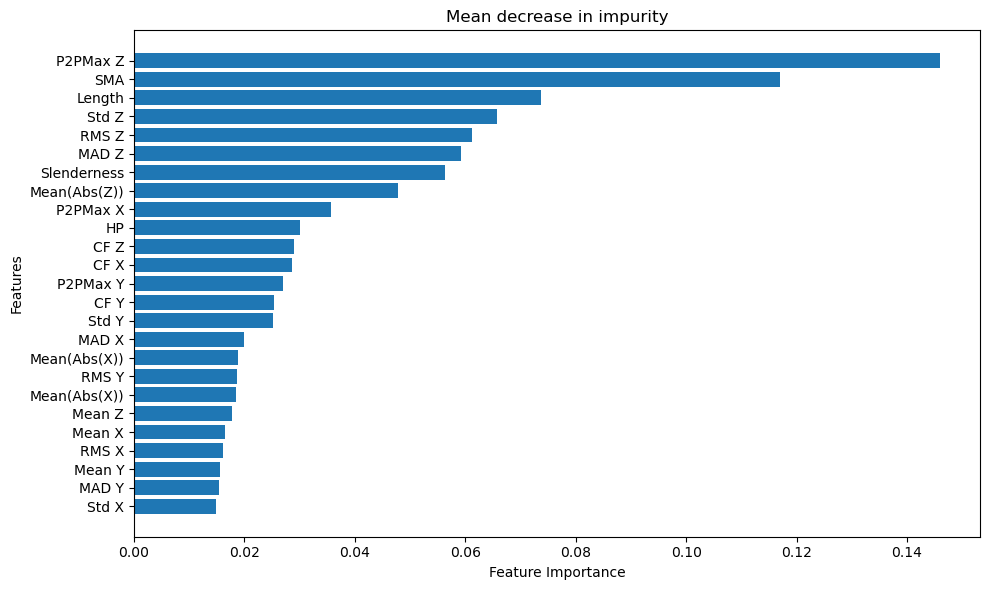

In [42]:
forest_importances = pd.Series(importances, index=feature_names)

indices = np.argsort(importances)
sorted_feature_importances = importances[indices]
sorted_feature_names = [feature_names[i] for i in indices]  # Replace 'your_feature_names' with the actual names of your features

# Create a horizontal bar graph
fig = plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_importances)), sorted_feature_importances, align="center")
plt.yticks(range(len(sorted_feature_importances)), sorted_feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Mean decrease in impurity")
plt.tight_layout()
plt.show()
fig.savefig('MDI.svg', format='svg',dpi=300, bbox_inches='tight',transparent=True, pad_inches=0.1)
plt.close()
# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=None, ax=ax)
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

In [30]:
from minisom import MiniSom
size = 30
som = MiniSom(size, size, len(features[0]),
              neighborhood_function='gaussian', sigma=1.5,
              random_seed=1)

som.pca_weights_init(features)
som.train_random(features, 6000, verbose=True)

 [ 1997 / 6000 ]  33% - 0:00:00 left 

 [ 3796 / 6000 ]  63% - 0:00:00 left 

 [ 5519 / 6000 ]  92% - 0:00:00 left 

 [ 6000 / 6000 ] 100% - 0:00:00 left 
 quantization error: 0.3986800878666719


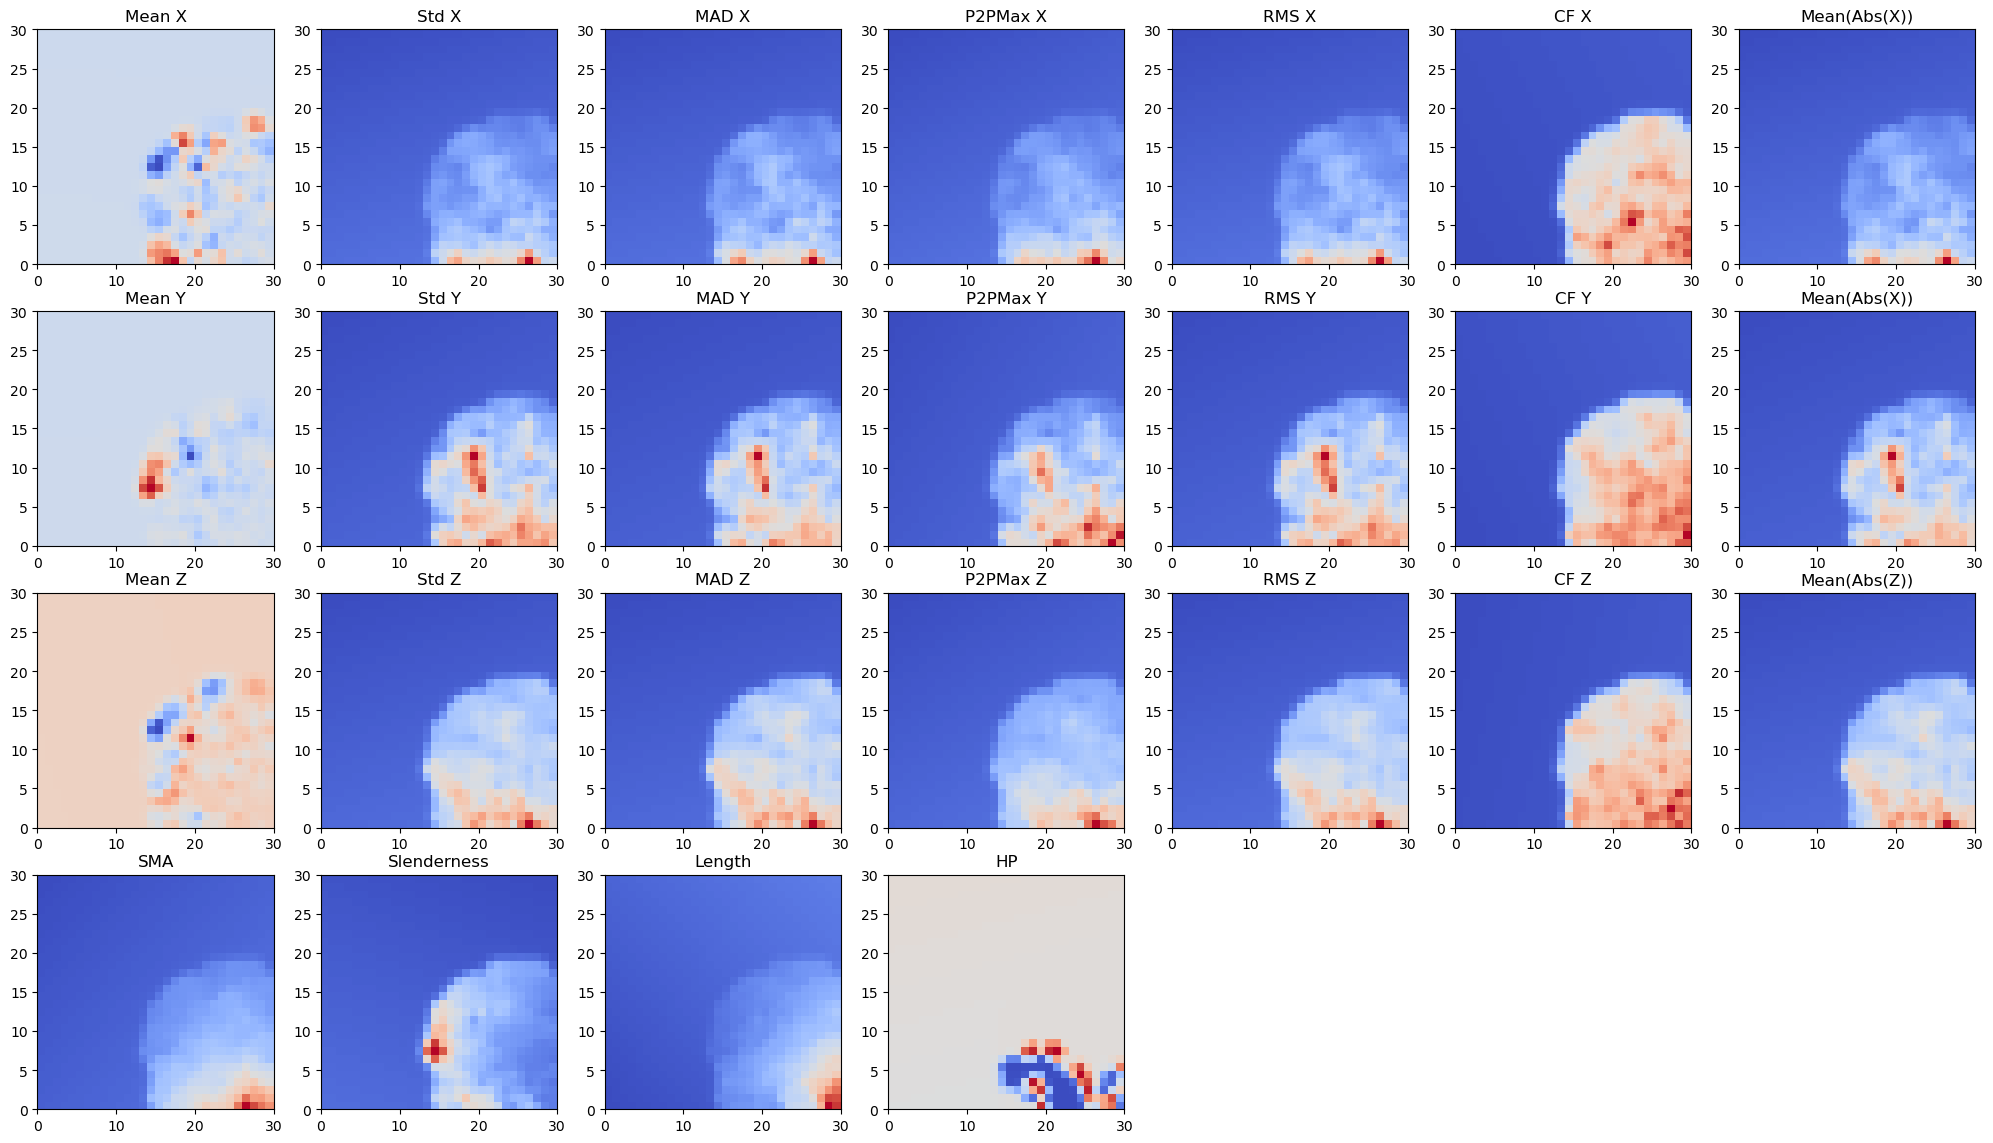

In [41]:
W = som.get_weights()

fig = plt.figure(figsize=(25, 25))
for i, f in enumerate(feature_names):
    plt.subplot(7, 7, i+1)
    plt.title(f)
    plt.pcolor(W[:,:,i].T, cmap='coolwarm')
#     plt.xticks(np.arange(size+1))
#     plt.yticks(np.arange(size+1))
plt.show()
# plt.tight_layout()
fig.savefig('FeatureSimilarity.svg', format='svg',dpi=300, bbox_inches='tight',transparent=True, pad_inches=0.1)
plt.close()

In [32]:
##### default length scale range : 0 - 1e5
##### 

In [33]:
from sklearn.mixture import GaussianMixture

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF


kernel = C(1.0, (1e-5, 1e5)) * RBF([1.0])
gpc_rbf_isotropic = GaussianProcessClassifier(kernel=kernel).fit(X_train, y_train)
kernel = C(1.0, (1e-5, 1e5)) * RBF([1.0, 1.0,1.0,1.0,1.0,1.0,1.0])
gpc_rbf_anisotropic = GaussianProcessClassifier(kernel=kernel, n_restarts_optimizer = 6, ).fit(X_train, y_train)

titles = ["Isotropic RBF", "Anisotropic RBF"]

for i, clf in enumerate((gpc_rbf_isotropic, gpc_rbf_anisotropic)):
    # Plot the predicted probabilities. For that, we will assign a color to
    # each point in the mesh [x_min, m_max]x[y_min, y_max].
    
    Z = clf.predict_proba(X_train)
    M = clf.predict(X_train)

    printClassResults(y_train, M, str(i) + 'Train')
    
    Z = clf.predict_proba(X_test)
    M = clf.predict(X_test)
    printClassResults(y_test, M, str(i) + 'Test')

ValueError: Anisotropic kernel must have the same number of dimensions as data (7!=25)

In [ ]:
gpc_rbf_anisotropic.kernel_.kernels

In [ ]:
X_test.shape

In [ ]:
gpc_rbf_anisotropic.predict_proba(X_test)

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

kernel =  C(1.0, (1e-3, 1e3)) * RBF([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

# Create a GaussianProcessClassifier with the custom kernel
gpc_rbf_anisotropic = GaussianProcessClassifier(kernel=kernel, n_restarts_optimizer=10)

# Define the hyperparameter grid for the RBF kernel
classifier = OneVsRestClassifier(gpc_rbf_anisotropic)

# Set up k-fold cross-validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=504)

# Perform k-fold cross-validation and get decision function scores

cv_scores = cross_val_score(classifier, features, y, cv=kf, scoring='accuracy')  # Corrected 'acuracy' to 'accuracy'

# Print the accuracy scores for each fold
for i, score in enumerate(cv_scores, start=1):
    print(f'Fold {i}: Accuracy = {score:.4f}')

# Print the mean and standard deviation of the cross-validation scores
print(f'\nMean Accuracy: {np.mean(cv_scores):.4f}')
print(f'Standard Deviation: {np.std(cv_scores):.4f}')

In [ ]:
kernel = C(1.0, (1e-5, 1e5)) * RBF([1.0, 1.0,1.0,1.0,1.0,1.0,1.0])
gpc_rbf_anisotropic = GaussianProcessClassifier(kernel=kernel, n_restarts_optimizer = 6, ).fit(X_train, y_train)

Z = gpc_rbf_anisotropic.predict_proba(X_train)
M = gpc_rbf_anisotropic.predict(X_train)

printClassResults(y_train, M,  'Train')

Z = gpc_rbf_anisotropic.predict_proba(X_test)
M = gpc_rbf_anisotropic.predict(X_test)
printClassResults(y_test, M, 'Test')

In [ ]:
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

In [ ]:
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import roc_auc_score
# store the fpr, tpr, and roc_auc for all averaging strategies
fpr, tpr, roc_auc = dict(), dict(), dict()
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_onehot_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")

for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(4):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= 4

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

In [ ]:
target_names = ['None Anomalies', 'Large cracks', 'Road bumps', 'Potholes']

In [ ]:
from itertools import cycle

fig, ax = plt.subplots(figsize=(6, 6))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue", "red"])
for class_id, color in zip(range(4), colors):
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"ROC curve for {target_names[class_id]}",
        color=color,
        ax=ax,
        
    )

plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend()
plt.show()

In [ ]:
gpc_rbf_anisotropic.kernel_.kernels

In [ ]:
gpc_rbf_anisotropic.predict_proba(X_test)

In [ ]:
meanFeatures = np.mean(features,axis=0)

In [ ]:
meanFeatures

In [ ]:
original_array = np.array([1, 2, 3, 4])

# Create the matrix
repeated_matrix = np.tile(meanFeatures, (10, 1))

print(repeated_matrix.shape)

In [ ]:
plt.figure(figsize=(10, 10))
x_min, x_max = features[:, 5].min(), features[:, 5].max() 
y_min, y_max = features[:, 6].min(), features[:, 6].max() 
xx, yy = np.meshgrid(features[:, 5], features[:, 6])
shp = xx.flatten().shape[0]

repeated_matrix = np.tile(meanFeatures, (shp, 1))

repeated_matrix[:,5] =xx.flatten()
repeated_matrix[:,6] =yy.flatten()


Prob = gpc_rbf_anisotropic.predict_proba(repeated_matrix)

Z = Prob.reshape((xx.shape[0], xx.shape[1],4))
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")

# Plot also the training points
# plt.scatter(X[:, 0], X[:, 1], c=np.array(["r", "g", "b"])[y], edgecolors=(0, 0, 0))
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
# plt.xlim(xx.min(), xx.max())
# plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title(
    "%s, LML: %.3f" % ('first class', gpc_rbf_anisotropic.log_marginal_likelihood(clf.kernel_.theta))
)

plt.tight_layout()
plt.show()


In [ ]:
# boundries can only show in 2-D space, we will choose two features based on length-scales to show boundries for each anomaly


features4class = {}
features4class['None anamalies'] = [1, 2]
features4class['Large cracks'] = [1, 2]
features4class['Road bumps'] = [5, 6]
features4class['Potholes'] = [2, 4]

Prob = gpc_rbf_anisotropic.predict_proba(features)
F0 = np.vstack((Z[:,0], np.sum(Z[:,1::], axis=1))).T
F1 = np.vstack((Z[:,0], np.sum(Z[:,1::], axis=1))).T
F2 = np.vstack((Z[:,0], np.sum(Z[:,1::], axis=1))).T
F3 = np.vstack((Z[:,0], np.sum(Z[:,1::], axis=1))).T

for index, (key, value) in enumerate(features4class.items()):
# create a mesh to plot in
    x_min, x_max = features[:, value[0]].min() - 1, features[:, value[0]].max() + 1
    y_min, y_max = features[:, value[1]].min() - 1, features[:, value[1]].max() + 1
    xx, yy = np.meshgrid(features[:, value[0]], features[:, value[1]])
    
    print(yy)
    
    Probfeatures2 = np.vstack((Prob[:,index], np.sum(Prob[:,value], axis=1))).T
    
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 2, index + 1)


    # Put the result into a color plot
    Z = Probfeatures2.reshape((xx.shape[0], xx.shape[1]))
    plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=np.array(["r", "g", "b"])[y], edgecolors=(0, 0, 0))
    plt.xlabel("Sepal length")
    plt.ylabel("Sepal width")
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(
        "%s, LML: %.3f" % (titles[i], gpc_rbf_anisotropic.log_marginal_likelihood(clf.kernel_.theta))
    )

    plt.tight_layout()
    plt.show()